 # Experiments for the basics of nn and torch implementations

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin1')
x_train, y_train, x_valid, y_valid = map(torch.tensor, [x_train, y_train, x_valid, y_valid])

In [4]:
# Dataset info
n,m = x_train.shape
n, n_feats = x_train.shape
c = (y_train.max() + 1).item()
nh = n_hidden = 50

In [5]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]

    def __call__(self, x):
        for layer in self.layers: x = layer(x)
        return x

In [6]:
model = Model(m, nh, c)
preds = model(x_train)
preds.shape

torch.Size([50000, 10])

 ## Experimenting with the basics for logsoftmax -- yet again

In [7]:
# setup some vars
n_train = 64
bs = 4
n_classes = 10
probs = torch.randn((bs, n_classes))
y = torch.randint(0, 9, (bs,))

In [8]:
x = probs
a = x.max(1, keepdim=True).values
x_norm = x - a
numerator = x_norm
logsumexp = x_norm.exp().sum(1, keepdim=True).log()
numerator.shape, logsumexp.shape
logsoftmax = numerator - logsumexp
logsoftmax

tensor([[-3.63, -4.00, -2.91, -2.85, -3.18, -1.69, -1.21, -1.24, -5.36, -3.80],
        [-2.45, -1.72, -3.00, -2.75, -1.03, -3.16, -4.40, -2.63, -2.25, -3.46],
        [-2.01, -4.50, -2.86, -3.37, -2.39, -1.48, -2.49, -1.64, -2.12, -3.04],
        [-2.34, -4.65, -2.51, -2.66, -2.41, -3.98, -3.22, -2.17, -1.06, -2.02]])

In [9]:
# Check against a version that doesn't use the normalisation with max
(torch.exp(x) / torch.exp(x).sum(1, keepdim=True)).log()

tensor([[-3.63, -4.00, -2.91, -2.85, -3.18, -1.69, -1.21, -1.24, -5.36, -3.80],
        [-2.45, -1.72, -3.00, -2.75, -1.03, -3.16, -4.40, -2.63, -2.25, -3.46],
        [-2.01, -4.50, -2.86, -3.37, -2.39, -1.48, -2.49, -1.64, -2.12, -3.04],
        [-2.34, -4.65, -2.51, -2.66, -2.41, -3.98, -3.22, -2.17, -1.06, -2.02]])

In [10]:
F.log_softmax(x, 1)

tensor([[-3.63, -4.00, -2.91, -2.85, -3.18, -1.69, -1.21, -1.24, -5.36, -3.80],
        [-2.45, -1.72, -3.00, -2.75, -1.03, -3.16, -4.40, -2.63, -2.25, -3.46],
        [-2.01, -4.50, -2.86, -3.37, -2.39, -1.48, -2.49, -1.64, -2.12, -3.04],
        [-2.34, -4.65, -2.51, -2.66, -2.41, -3.98, -3.22, -2.17, -1.06, -2.02]])

In [11]:
# wrap into function
def log_softmax(x):
    x_norm = x - x.max(1, keepdim=True).values
    numerator = x_norm
    logsumexp = x_norm.exp().sum(1, keepdim=True).log()
    logsoftmax = numerator - logsumexp
    return logsoftmax

assert torch.allclose(log_softmax(probs), F.log_softmax(probs, 1)), 'did not find equality with torch in log_softmax implementation'

In [12]:
log_likelihood = log_softmax(probs)
preds = log_likelihood[range(log_likelihood.shape[0]), y]
nll = -preds.mean()

print(nll, F.nll_loss(F.log_softmax(probs, 1), y), F.cross_entropy(probs, y))

tensor(3.22) tensor(3.22) tensor(3.22)


In [13]:
# wrap into function
def cross_entropy(probs, targets):
    log_likelihood = log_softmax(probs)
    preds = log_likelihood[range(log_likelihood.shape[0]), targets]
    nll = -preds.mean()
    return nll

assert torch.allclose(cross_entropy(probs, y), F.cross_entropy(probs, y)), 'did not find equality with torch in cross_entropy implementation'

 # Basic training loop
 Can now just use the torch implementation of log_softmax and cross_entropy
 - Get model preds
 - compare against labels and calculate loss
 - calculate gradient of loss with respece to model params
 - update params

In [14]:
loss_func = F.cross_entropy

In [15]:
bs = 50
xb = x_train[:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06], grad_fn=<SelectBackward0>),
 torch.Size([50, 10]))

In [16]:
yb = y_train[:bs]
yb.shape

torch.Size([50])

In [17]:
loss_func(preds, yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [18]:
# About the same as this for random init model and c classes
-np.log(1/c)

2.3025850929940455

In [19]:
preds.argmax(1)

tensor([3, 9, 3, 8, 5, 9, 3, 9, 3, 9, 5, 3, 9, 9, 3, 9, 9, 5, 8, 7, 9, 5, 3, 8, 9, 5, 9, 5, 5, 9, 3, 5, 9, 7, 5, 7, 9, 9, 3, 9, 3, 5, 3, 8,
        3, 5, 9, 5, 9, 5])

In [20]:
def accuracy(preds, labels): return (preds.argmax(dim=1) == labels).float().mean()

In [21]:
accuracy(preds, yb)

tensor(0.08)

In [22]:
lr = 0.5
epochs = 3

In [23]:
def report(loss, preds, yb): print(f'loss: {loss:.2f}, accuracy: {accuracy(preds, yb):.2f}')

In [24]:
xb, yb = x_train[:bs], y_train[:bs]
preds = model(xb)
report(loss_func(preds, yb), preds, yb)

loss: 2.30, accuracy: 0.08


In [25]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for layer in model.layers:
                if hasattr(layer, 'weight'):
                    layer.weight -= lr * layer.weight.grad
                    layer.bias -= lr * layer.bias.grad
                    layer.weight.grad.zero_()  # TODO test if can just set to None for simplicity 
                    layer.bias.grad.zero_()
    report(loss, preds, yb)

loss: 0.11, accuracy: 0.96
loss: 0.13, accuracy: 0.96
loss: 0.10, accuracy: 0.96


## Parameters in nn.Module

In [26]:
m1 = nn.Module()
m1.foo = nn.Linear(3, 4)
print(m1)
print(list(m1.parameters()))

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)
[Parameter containing:
tensor([[ 0.06,  0.35,  0.40],
        [ 0.49, -0.39,  0.20],
        [ 0.26, -0.53,  0.22],
        [-0.37, -0.38, -0.05]], requires_grad=True), Parameter containing:
tensor([ 0.11, -0.45, -0.21, -0.57], requires_grad=True)]


In [27]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [28]:
class MLP(nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_out)
        self.relu = nn.ReLU()
    
    def forward(self, x): return self.l2(self.relu(self.l1(x)))

In [29]:
model = MLP(n_feats, nh, c)
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [30]:
for name, layer in model.named_children(): print(f'{name}: {layer}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [31]:
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [32]:
def fit():
    for epoch in range(3):
        for i in range(0, n, bs):
            s = slice(i, min(n, i+bs))
            xb, yb = x_train[s], y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= lr * p.grad
                model.zero_grad()
        report(loss, preds, yb)

In [33]:
fit()

loss: 0.12, accuracy: 0.98
loss: 0.07, accuracy: 0.98
loss: 0.05, accuracy: 1.00


### Registering modules

In [34]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)

    def __setattr__(self, k, v):
        if not k.startswith('_'): self._modules[k] = v
        super().__setattr__(k, v)

    def __repr__(self): return f'{self._modules}'

    def parameters(self):
        for layer in self._modules.values(): yield from layer.parameters()


In [35]:
mdl = MyModule(m, nh, c)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [36]:
for p in mdl.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


### Registering modules with our Model class

Can still use the list of layers approach, but have to register the modules

In [37]:
from functools import reduce

In [38]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c)]

In [39]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, layer in enumerate(self.layers): super().add_module(f'layer{i}', layer)
    
    # def forward(self, x):
    #     for layer in self.layers: x = layer(x)
    #     return x
    
    def forward(self, x): return reduce(lambda val, layer: layer(val), self.layers, x)

In [40]:
model = Model(layers)
model

Model(
  (layer0): Linear(in_features=784, out_features=50, bias=True)
  (layer1): ReLU()
  (layer2): Linear(in_features=50, out_features=10, bias=True)
)

In [41]:
model(xb).shape

torch.Size([50, 10])

### nn.ModuleList does this and nn.Sequential wraps it all in a single class

In [42]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers: x = layer(x)
        return x

In [43]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [44]:
fit()

loss: 0.13, accuracy: 0.94
loss: 0.08, accuracy: 0.98
loss: 0.04, accuracy: 1.00


In [45]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

loss: 0.15, accuracy: 0.94
loss: 0.06, accuracy: 1.00
loss: 0.05, accuracy: 0.98


(tensor(0.01, grad_fn=<NllLossBackward0>), tensor(1.))

### optim

In [46]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params, self.lr = list(params), lr

    def step(self):
        with torch.no_grad():
            for p in self.params: p -= self.lr * p.grad

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [47]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))
opt = Optimizer(model.parameters())

In [48]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

loss: 0.14, accuracy: 0.94
loss: 0.13, accuracy: 0.96
loss: 0.09, accuracy: 0.96


Just use the functionality from torch now in torch.optim.XXX e.g. optim.SGD

In [49]:
from torch import optim

In [50]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))
    return model, optim.SGD(model.parameters(), lr=lr)

In [51]:
model, opt = get_model()

In [52]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb, yb = x_valid[s], y_valid[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

loss: 0.14, accuracy: 0.94
loss: 0.10, accuracy: 0.94
loss: 0.10, accuracy: 0.98


## Dataset and Dataloader

### Dataset

Wrap both the inputs and targets into a single object for convenience

In [55]:
class Dataset:
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [90]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert(len(train_ds) == len(x_train))
xb, yb = train_ds[:5]
assert(xb.shape == (5, *x_train[0].shape))
assert(yb.shape == (5, *y_train[0].shape))

In [91]:
model, opt = get_model()
for epoch in range(epochs):
    for i in range(0, n, bs):
        xb, yb = train_ds[i:i+bs]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

loss: 0.12, accuracy: 0.94
loss: 0.09, accuracy: 0.98
loss: 0.07, accuracy: 0.96


### DataLoader class to handle datasets, batching, sampling etc.

In [95]:
class DataLoader:
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), bs): yield self.ds[i:i+self.bs]

In [96]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [97]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

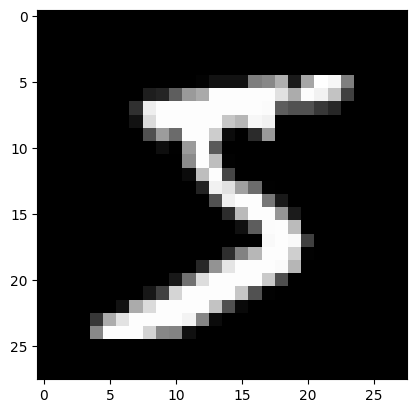

In [98]:
plt.imshow(xb[0].view(28, 28))

In [99]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

In [100]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(preds, yb)

loss: 0.12, accuracy: 0.96
loss: 0.09, accuracy: 0.96
loss: 0.06, accuracy: 0.96


(tensor(0.15, grad_fn=<NllLossBackward0>), tensor(0.16))

### Random sampling

In [85]:
import random

In [135]:
class Sampler:
    def __init__(self, ds, shuffle=False):
        self.n = n
        self.shuffle = shuffle
    def __iter__(self):
        idxs = list(range(self.n))
        if self.shuffle: random.shuffle(idxs)
        return iter(idxs)

In [136]:
ss = Sampler(train_ds, shuffle=False)

In [137]:
it = iter(ss)
for _ in range(5): print(next(it))

0
1
2
3
4


In [138]:
from itertools import islice

In [152]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[39614, 16470, 19166, 551, 7498]

In [153]:
import fastcore.all as fc

In [162]:
class BatchSampler:
    def __init__(self, sampler, bs, drop_last=False): self.sampler, self.bs, self.drop_last = sampler, bs, drop_last
    def __iter__(self): yield from fc.chunked(self.sampler, self.bs, drop_last=self.drop_last)

In [169]:
batchs = BatchSampler(ss, 4, drop_last=False)
list(islice(batchs, 5))

[[46548, 42175, 12446, 32852],
 [28931, 22772, 46332, 6296],
 [15630, 34168, 34914, 40482],
 [20759, 32337, 14811, 31966],
 [36817, 1887, 46621, 29818]]

In [182]:
j, k = zip(*[train_ds[i] for i in range(5)])
k


(tensor(5), tensor(0), tensor(4), tensor(1), tensor(9))

In [185]:
# there's not really anything that needs doing for colate
# batch is expected to be a list of len-2-tuples with x,y at each element.
# we want to pull out the full batch of x and full batch of y in this collate fn -- collate x, collate y
def collate(batch):
    xs, ys = zip(*batch)
    return torch.stack(xs), torch.stack(ys)

In [187]:
class DataLoader:
    def __init__(self, ds, batchs, collate_fn=collate):
        self.ds, self.batchs, self.collate_fn = ds, batchs, collate_fn
    def __iter__(self):
        yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [188]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [191]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

tensor(3)

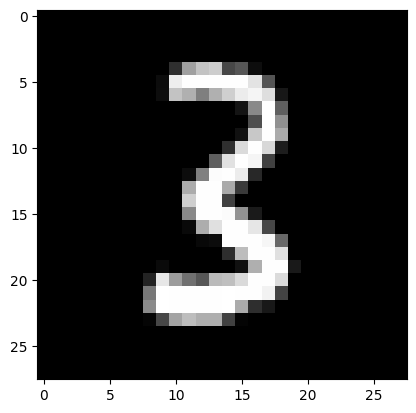

In [192]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [193]:
model, opt = get_model()
fit()

loss: 0.19, accuracy: 0.92
loss: 0.07, accuracy: 0.98
loss: 0.16, accuracy: 0.98
